In [1]:
import numpy as np
import matplotlib.pyplot as plt
from h5py import File

%matplotlib inline

In [2]:
def read_h5_to_numpy(
    file_path: str, subset_type: str, response_type: str
):
        """
        Reads data from an HDF5 file and converts it to numpy arrays. Normalizes the output data if the scaler is provided.
        Returns:
            Tuple[ndarray[Any, dtype[Any]], ndarray[Any, dtype[Any]]]: A tuple containing the input data (X) and the output data (y).
        """  # noqa: E501
        with File(file_path, "r") as h5file:
            # Read as numpy arrays
            X = np.asarray(h5file[subset_type]["stimulus"])
            y = np.asarray(
                h5file[subset_type]["response"][response_type]
            )
        X = X.astype("float32") / 255.0
        y = y.astype("float32")

        return X, y

In [4]:
x, y = read_h5_to_numpy("../data/neural_code_data/naturalscene.h5", 'train', 'firing_rate_10ms')

In [38]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.3)

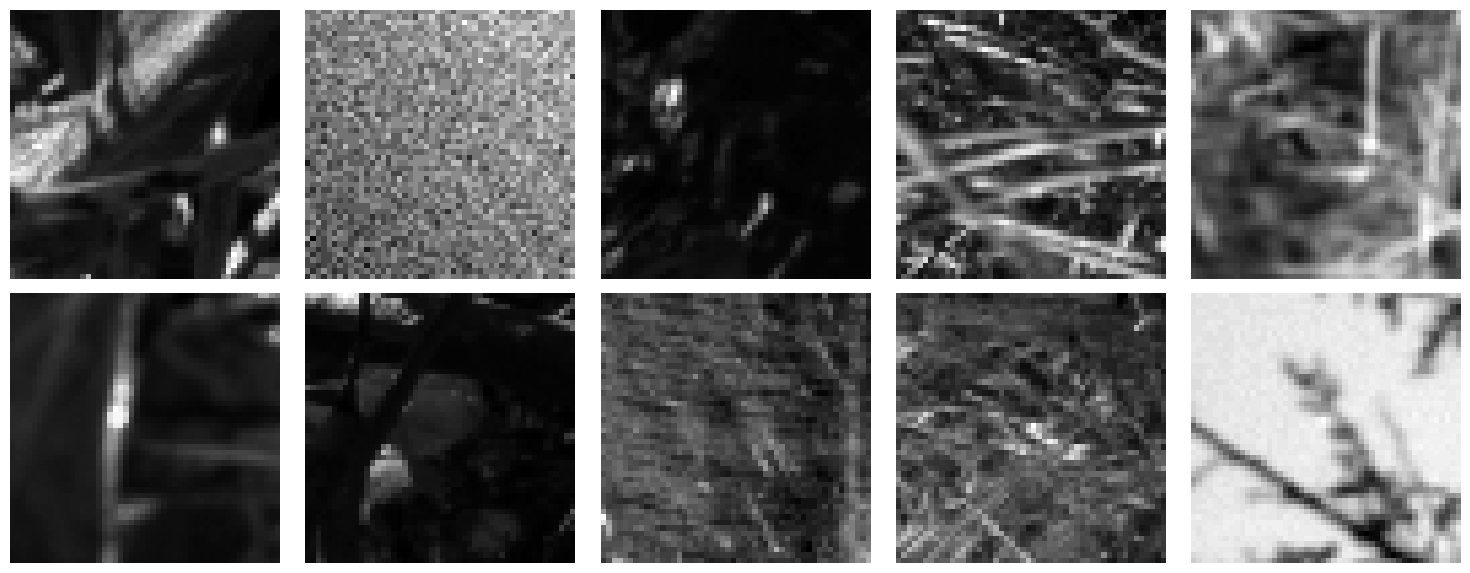

In [39]:
# Plot 10 random images from x
# Set random seed for reproducibility
np.random.seed(42)
random_indices = np.random.choice(x.shape[0], 10, replace=False)
x_sample = x[random_indices]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_sample[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()
fig.savefig('plots/sample_images.pdf')

In [35]:
def plot_spike_images(responses: np.ndarray, images: np.ndarray, N: int = 5, save=False):
    """
    Plots the last N images when a spike (response > 0) is detected and also plots the responses below them.
    
    Parameters:
    - responses: 1D numpy array of neural responses.
    - images: 3D numpy array of shape (num_samples, 50, 50) containing grayscale images.
    - N: Number of images to plot before the detected spike.
    """
    spike_indices = np.where(responses > 0)[0]  # Indices where response > 0
    
    if len(spike_indices) == 0:
        print("No spikes detected.")
        return
    
    for spike_idx in spike_indices:
        start_idx = max(0, spike_idx - N)  # Ensure valid index range
        selected_indices = np.arange(start_idx, spike_idx + 1)
        selected_responses = responses[selected_indices]
        
        fig = plt.figure(figsize=(12, 4))
        gs = fig.add_gridspec(2, spike_idx - start_idx + 1, height_ratios=[3, 1])
        # fig.suptitle(f"Spike detected: {responses[spike_idx]:.2f} at index {spike_idx}")
        
        for i, idx in enumerate(selected_indices):
            ax = fig.add_subplot(gs[0, i])
            ax.imshow(images[idx], cmap='gray')
            ax.axis('off')
            ax.set_title(str(idx))
        
        ax_response = fig.add_subplot(gs[1, :])
        ax_response.plot(selected_indices, selected_responses, marker='o', linestyle='-', color='b')
        ax_response.set_title("RGC Responses")
        ax_response.set_xlabel("Time step")
        ax_response.set_ylabel("Firing rate [Hz]")
        
        plt.tight_layout()
        plt.show()
        if save:
            fig.savefig(f"plots/spike_images_{spike_idx}.pdf")

# Channel 0

In [6]:
y_0 = y[0]

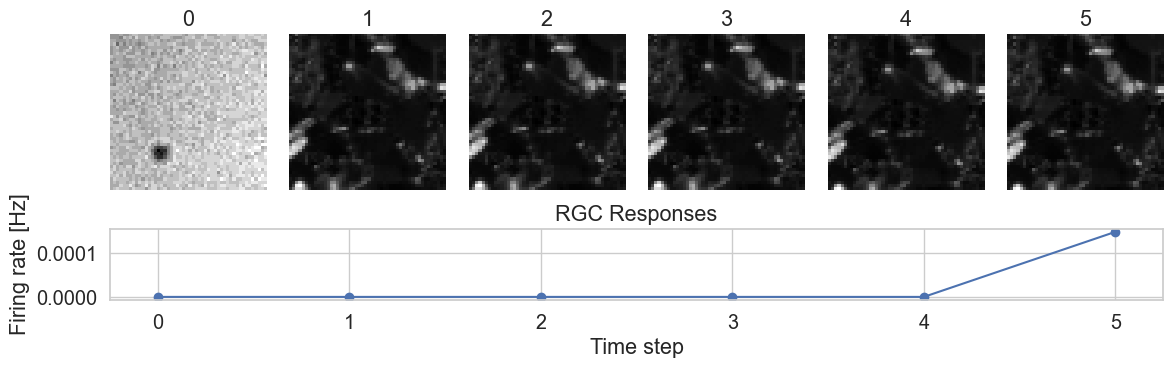

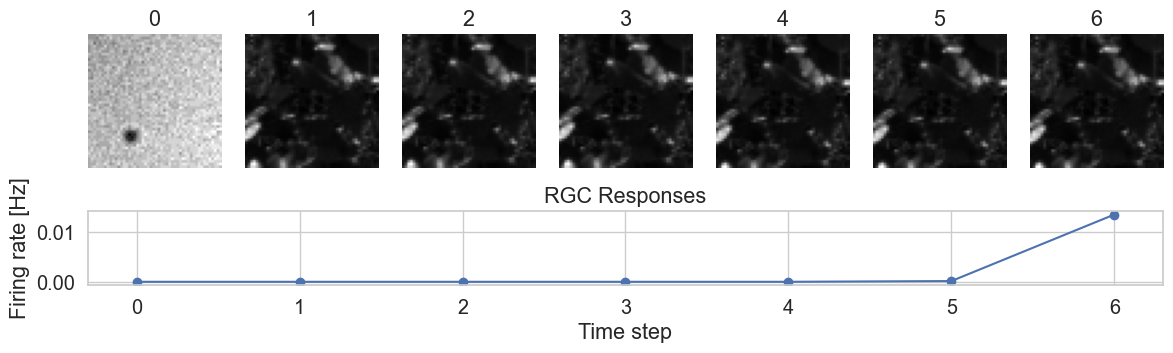

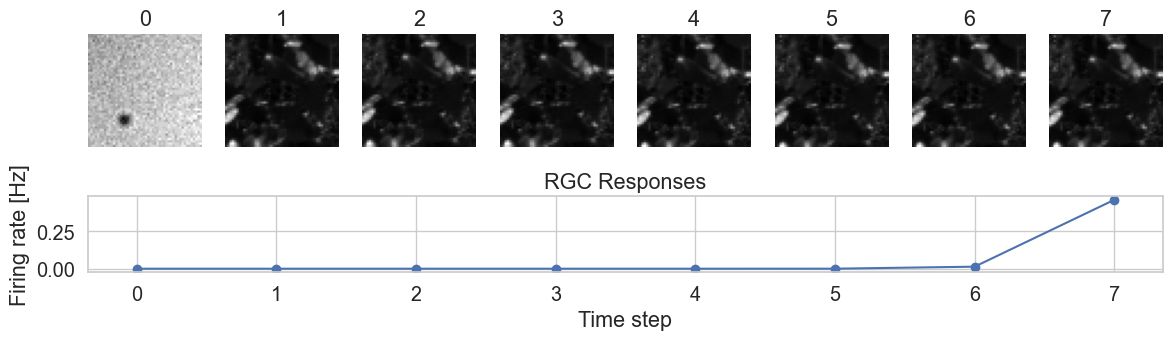

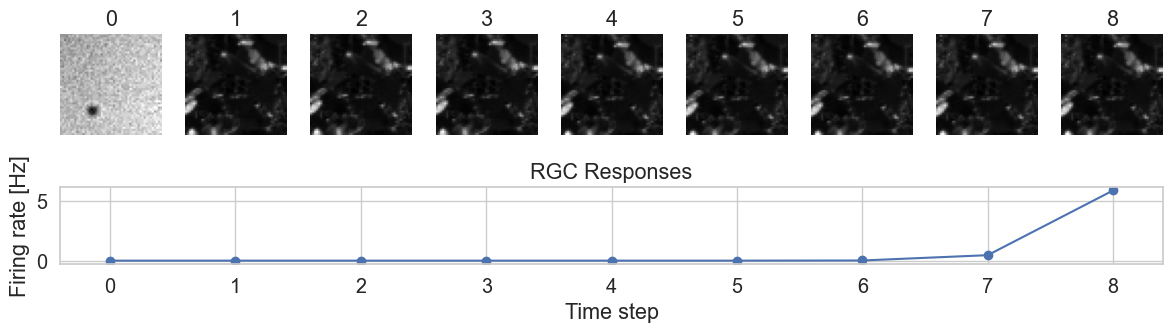

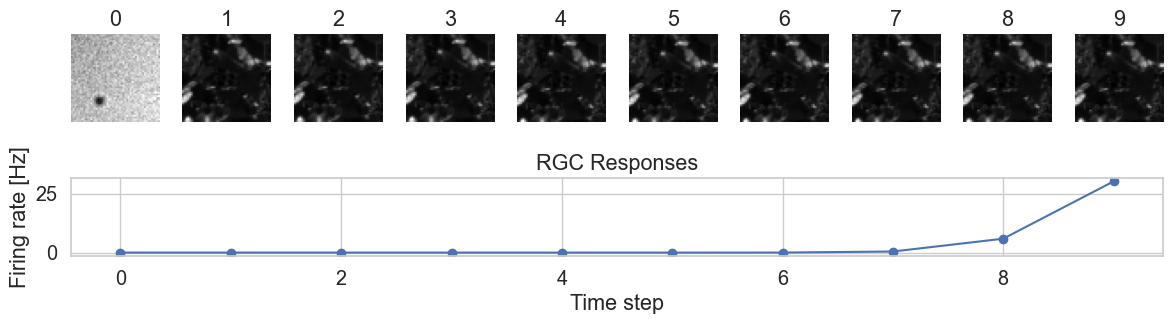

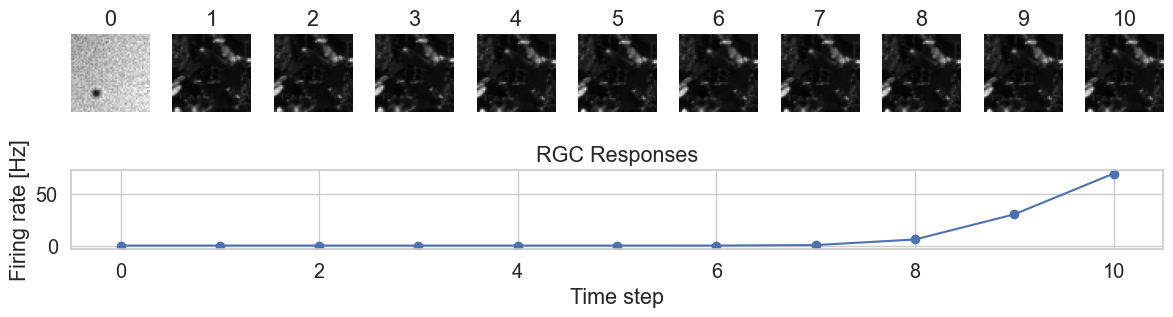

In [40]:
# take spikes for the first 100 data points
plot_spike_images(y_0[809:820], x[809:820], N=10, save=True)

# Channel 1

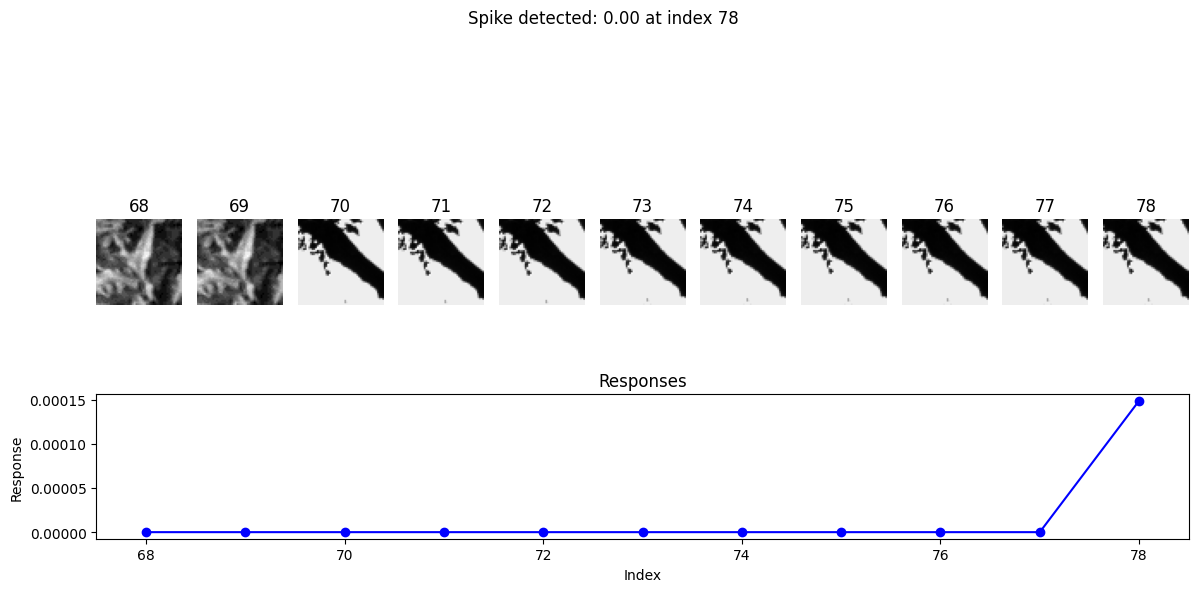

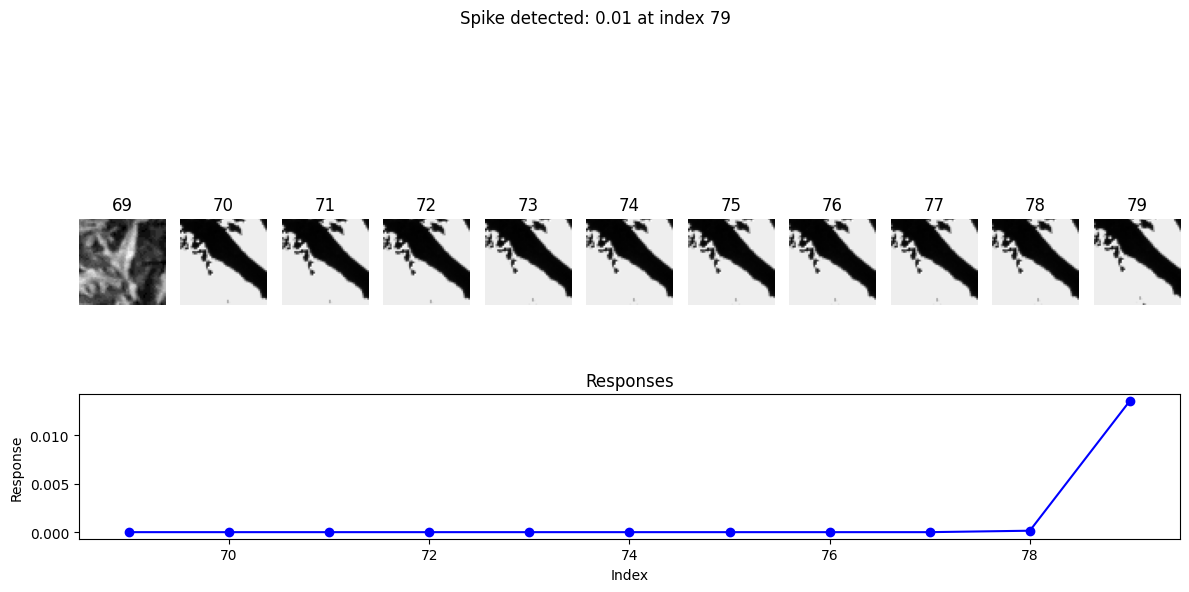

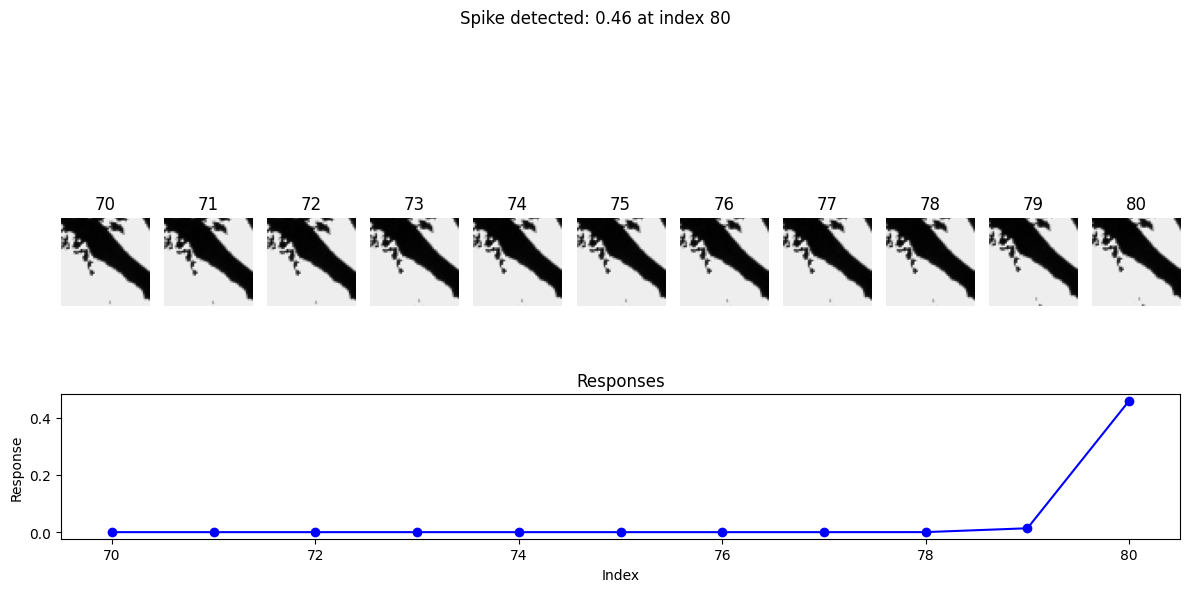

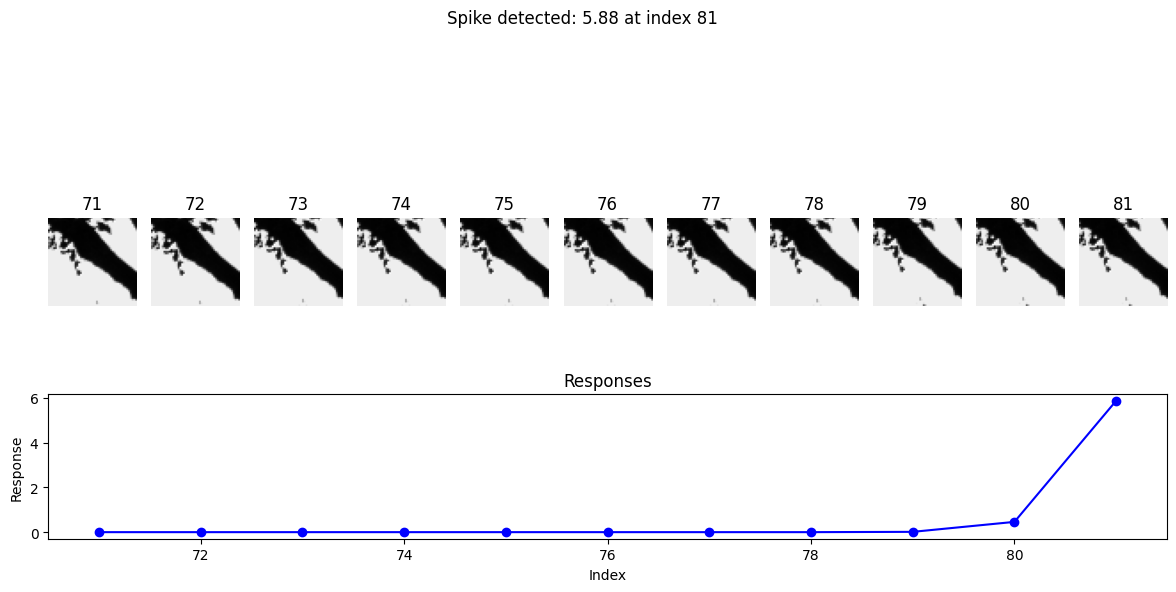

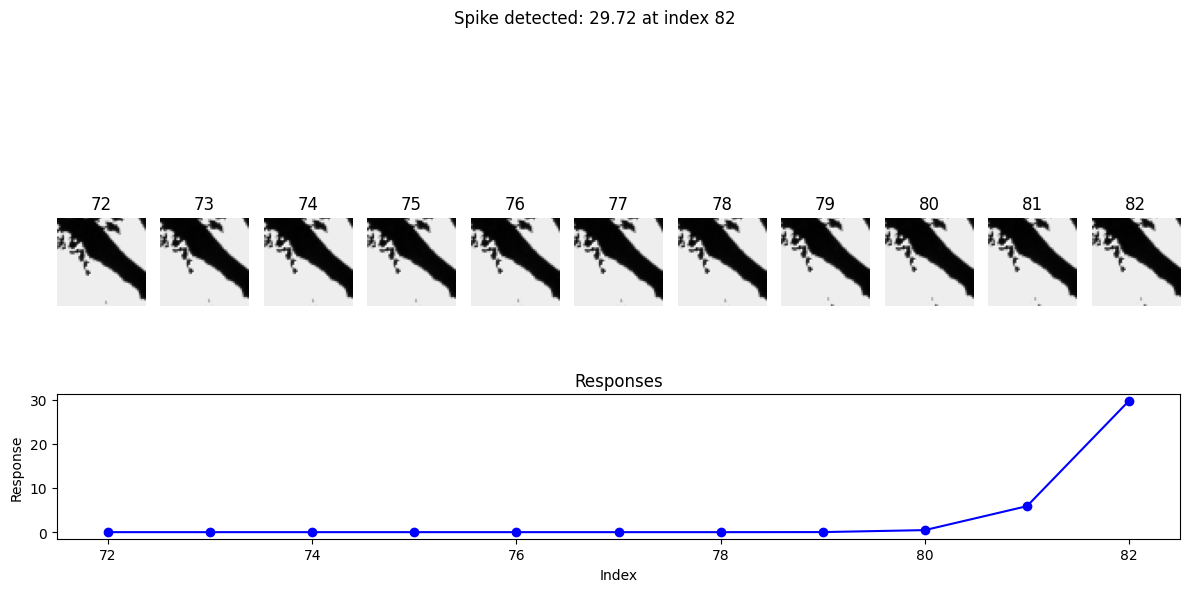

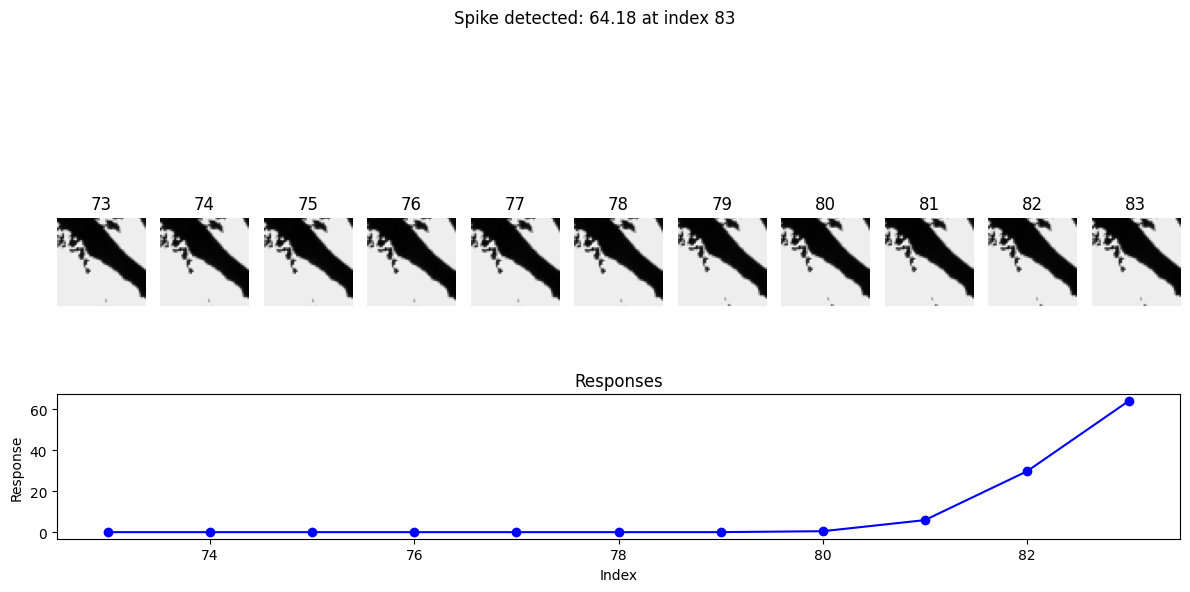

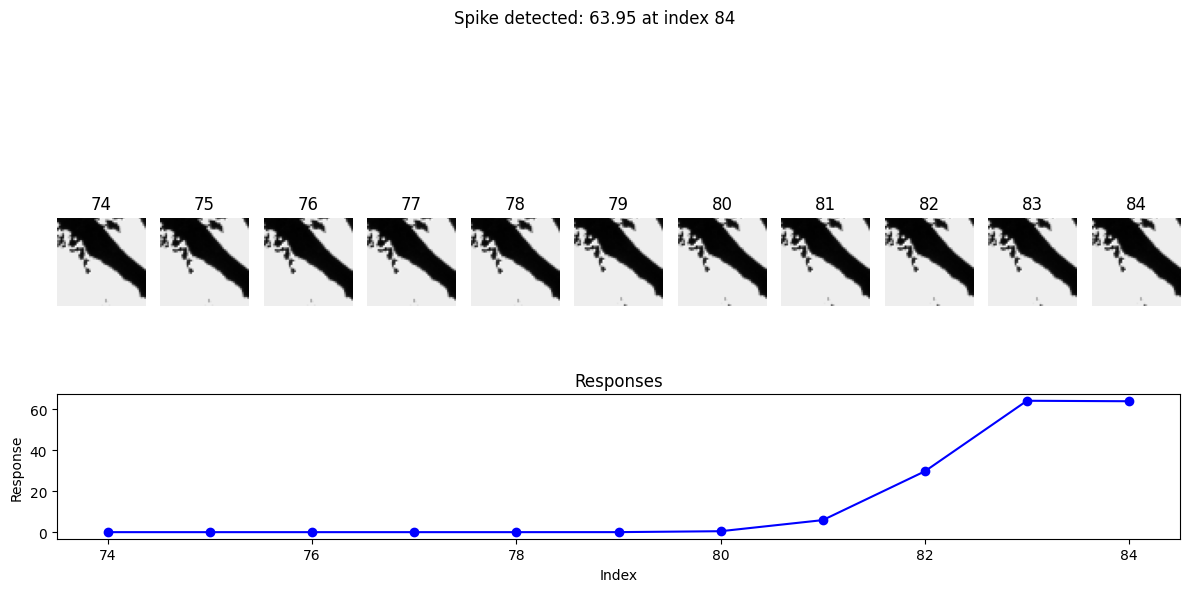

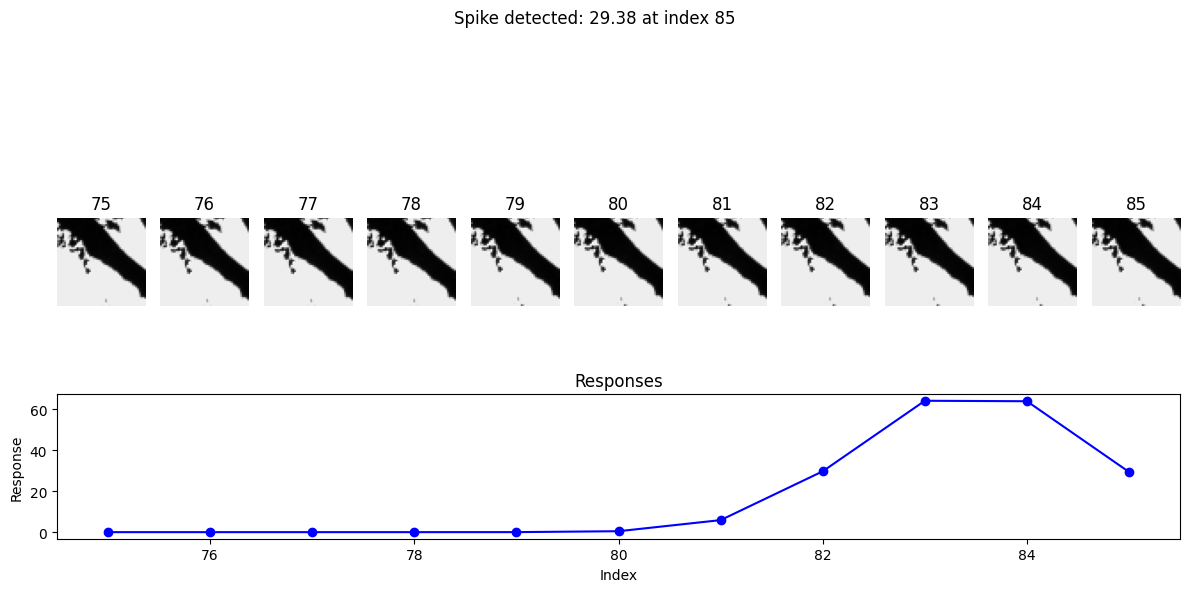

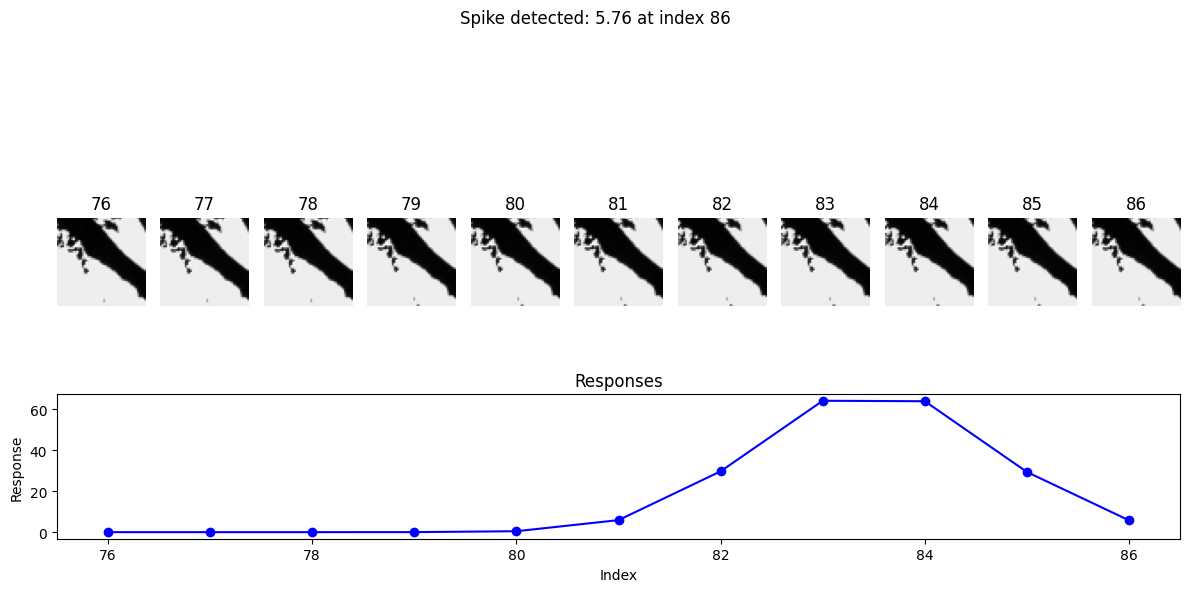

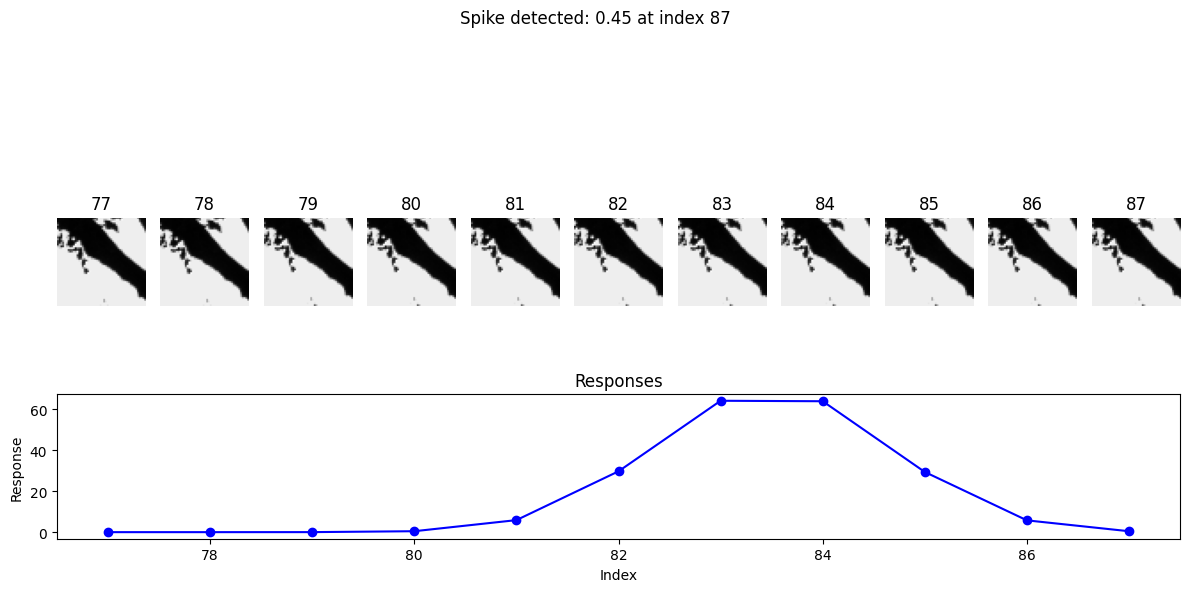

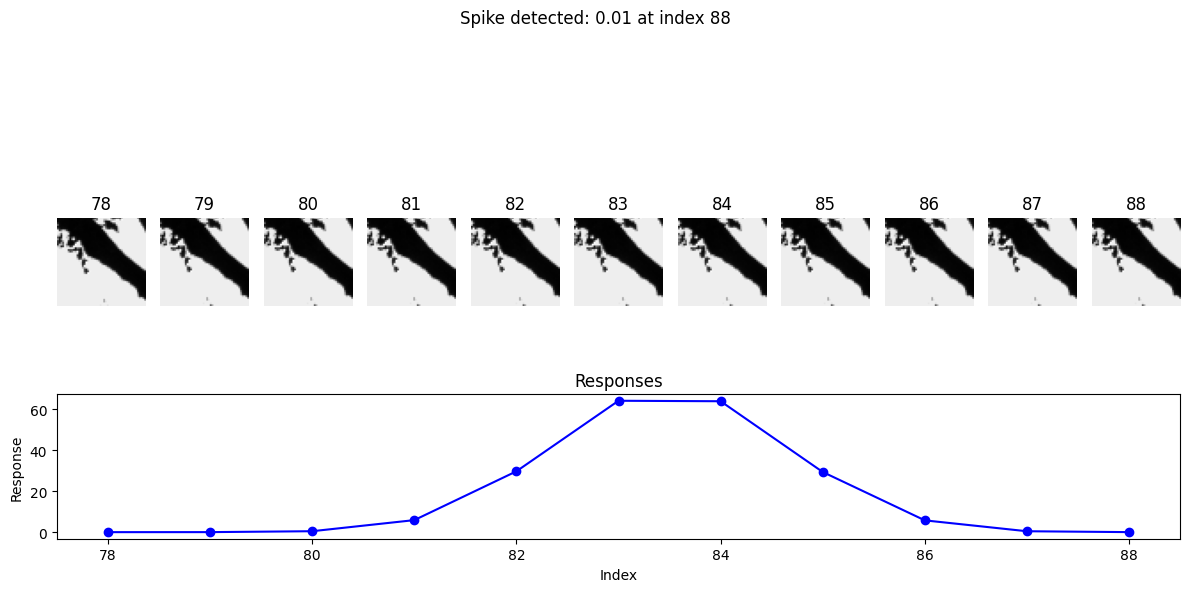

In [16]:
y_1 = y[1]
plot_spike_images(y_1[200:300], x[200:300], N=10)

# Channel 2

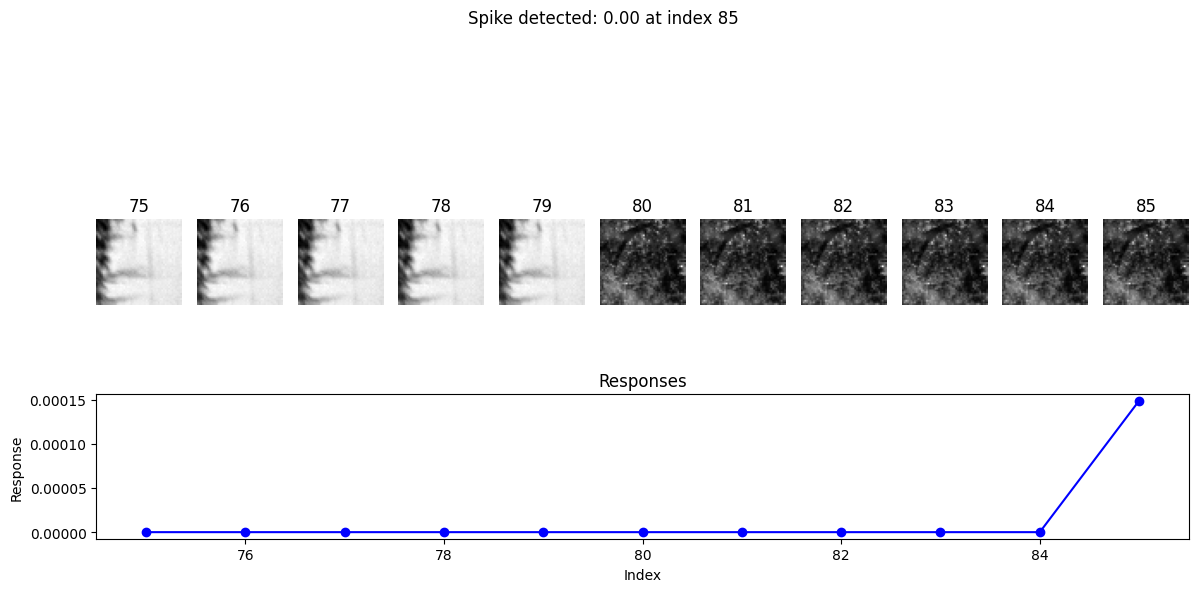

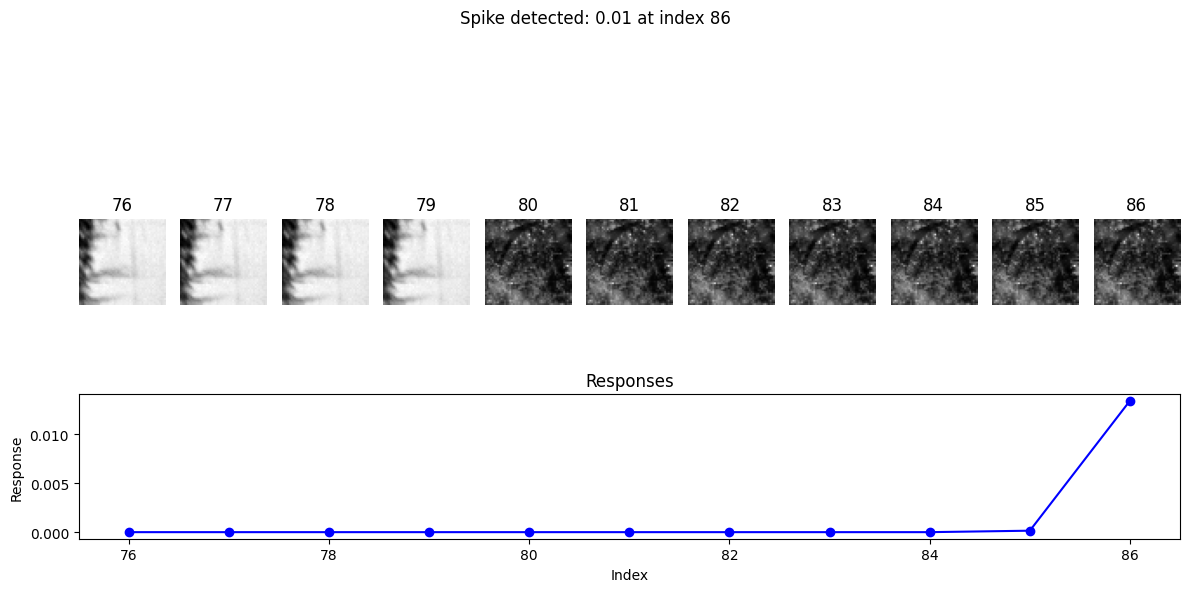

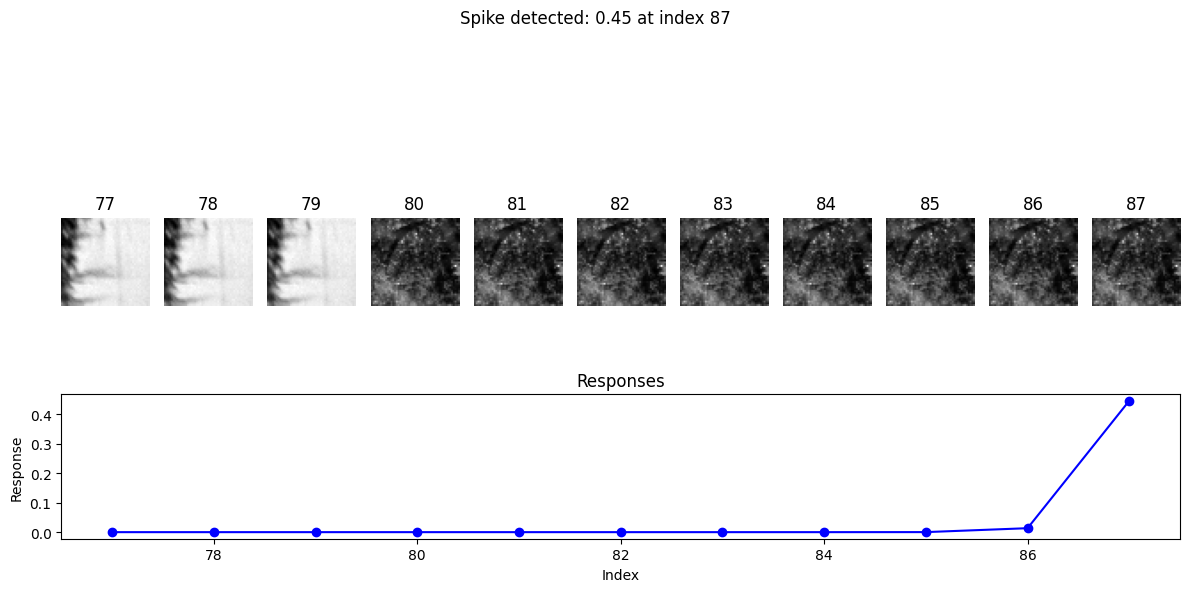

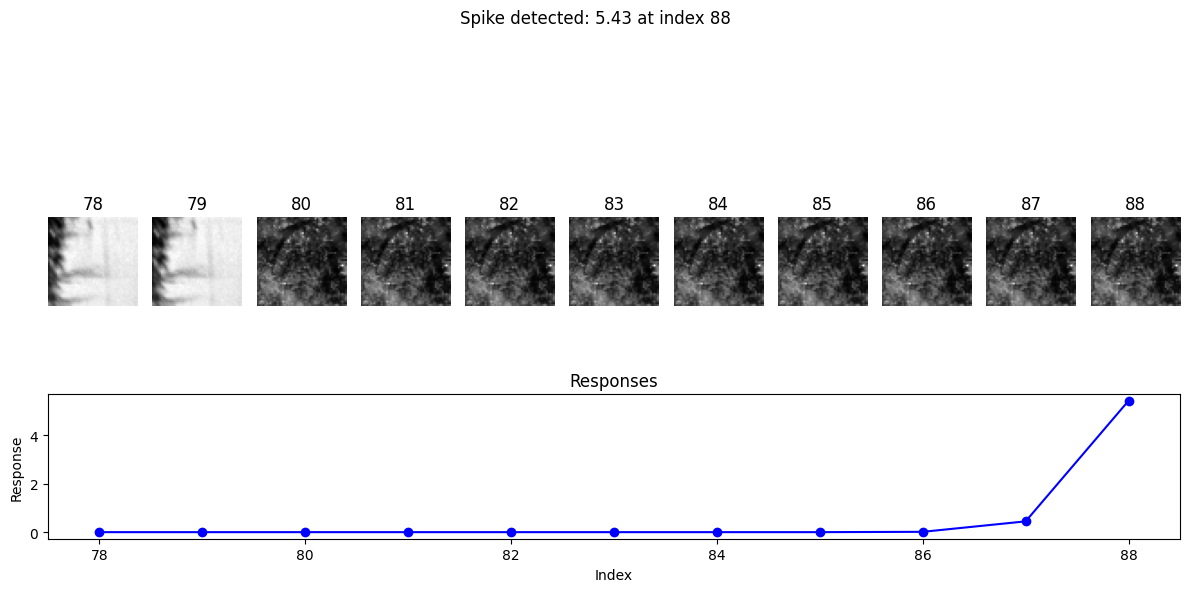

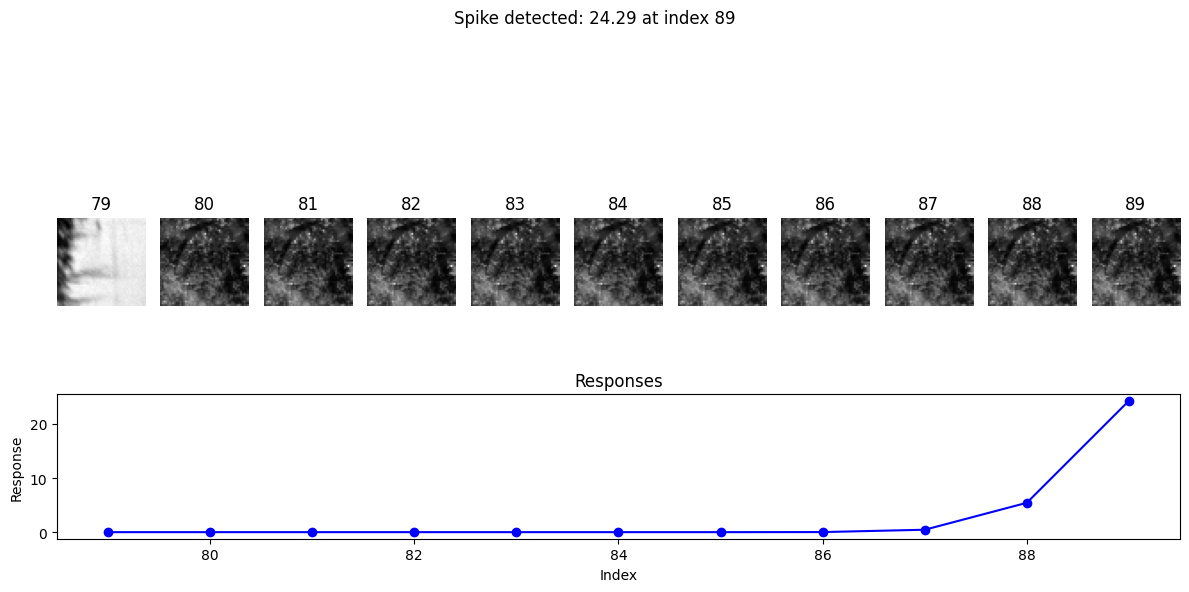

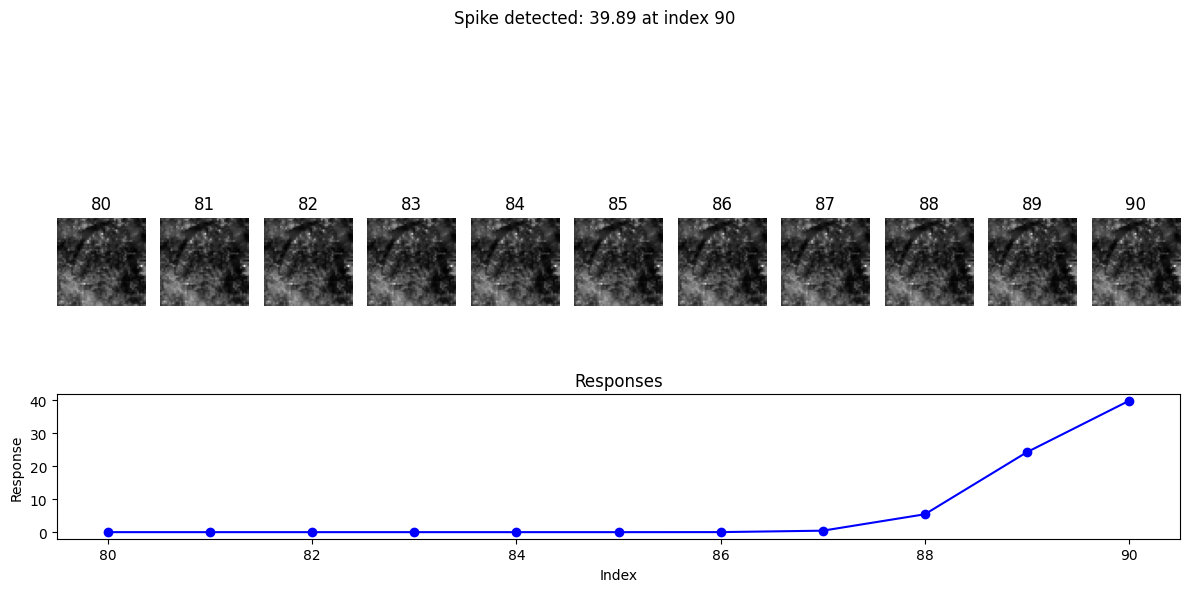

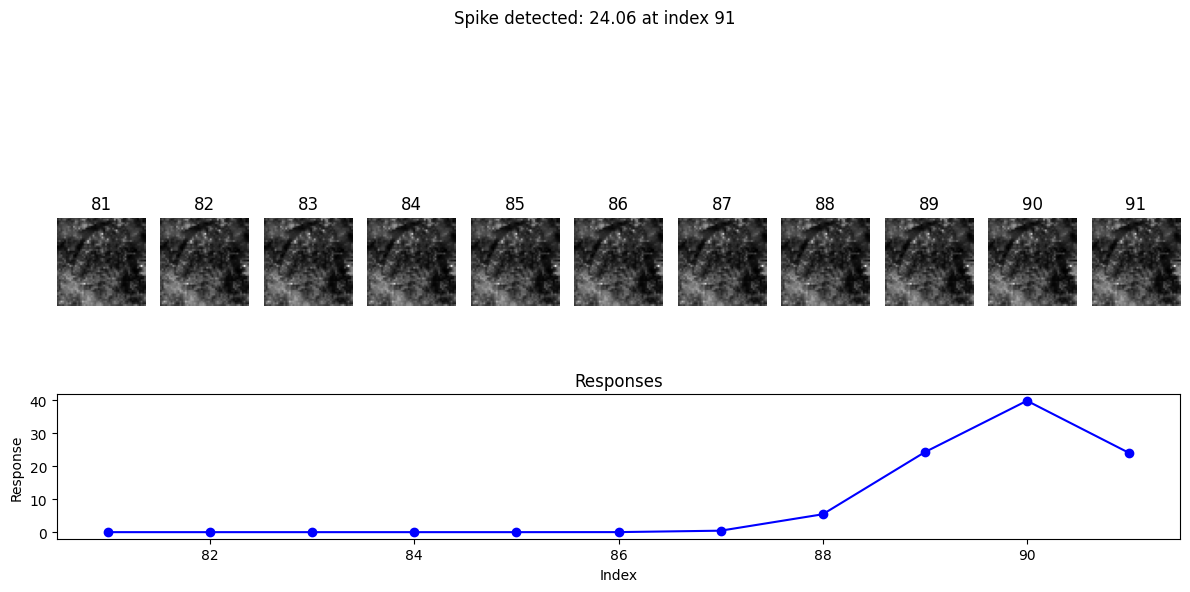

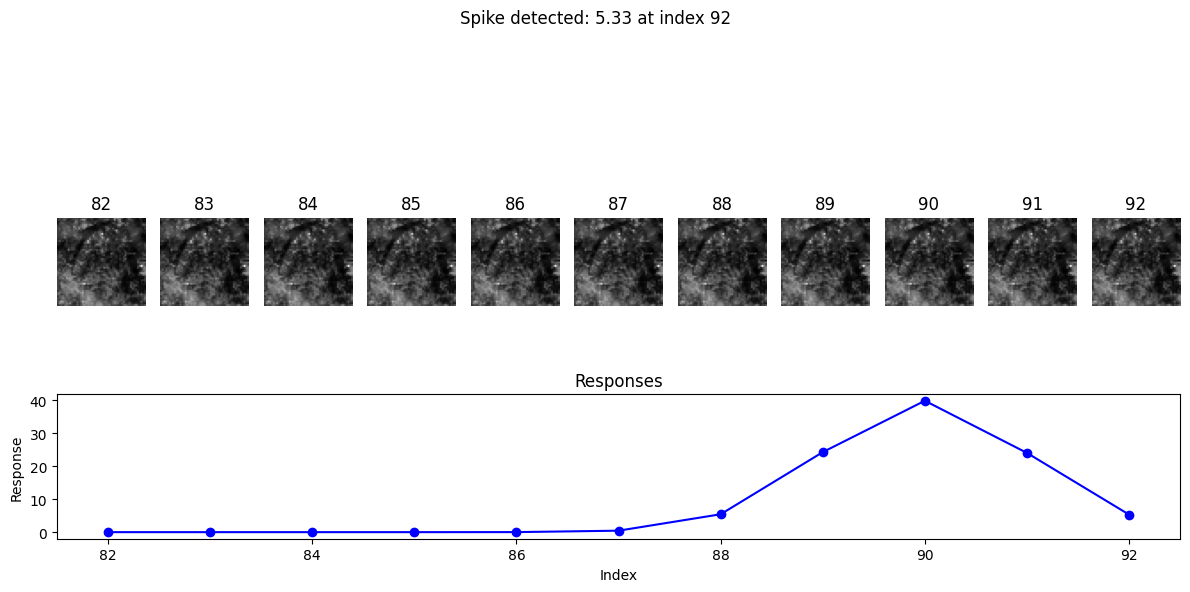

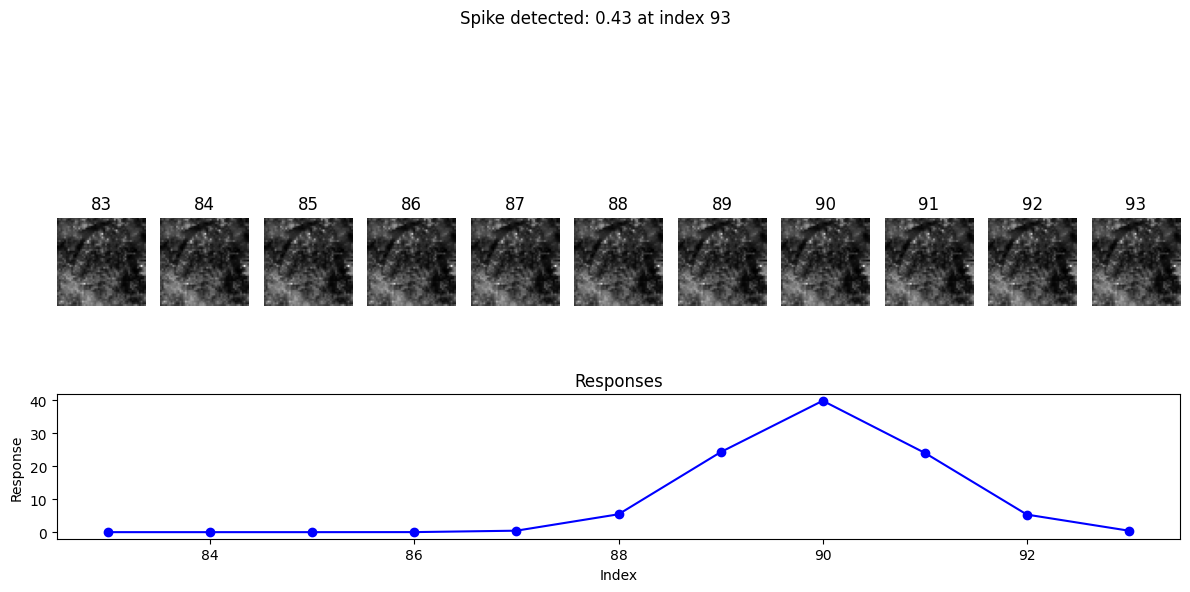

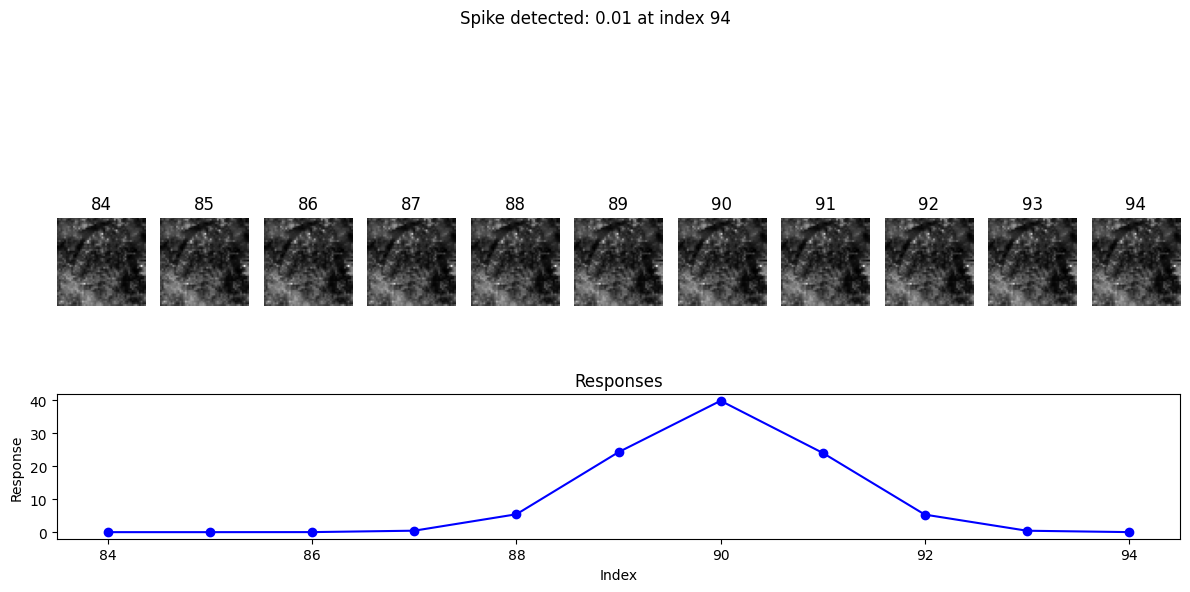

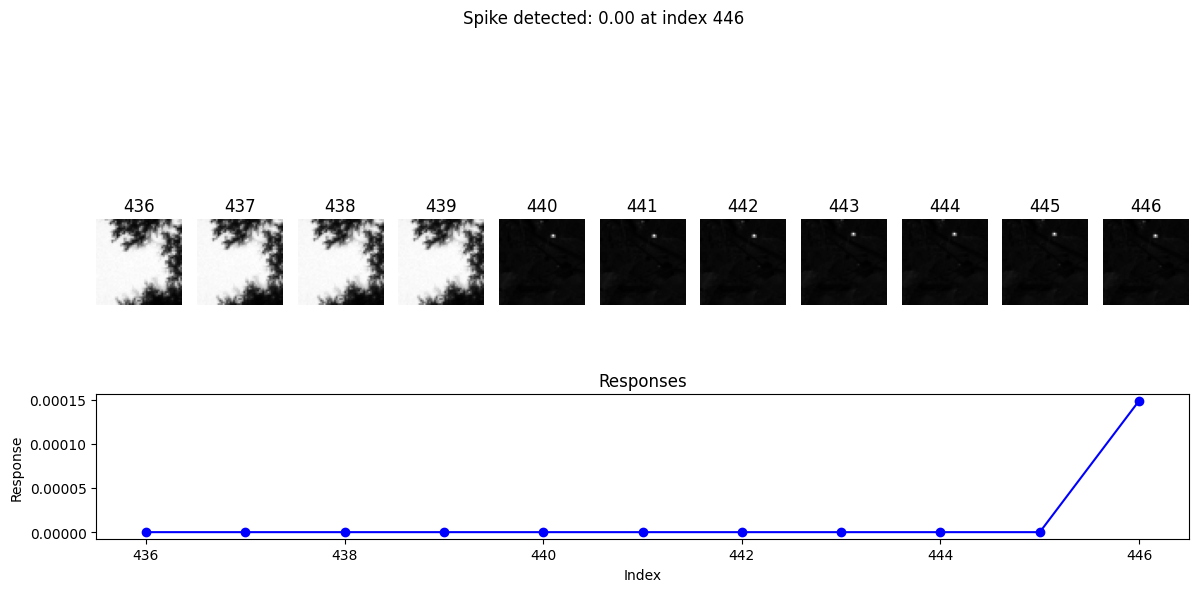

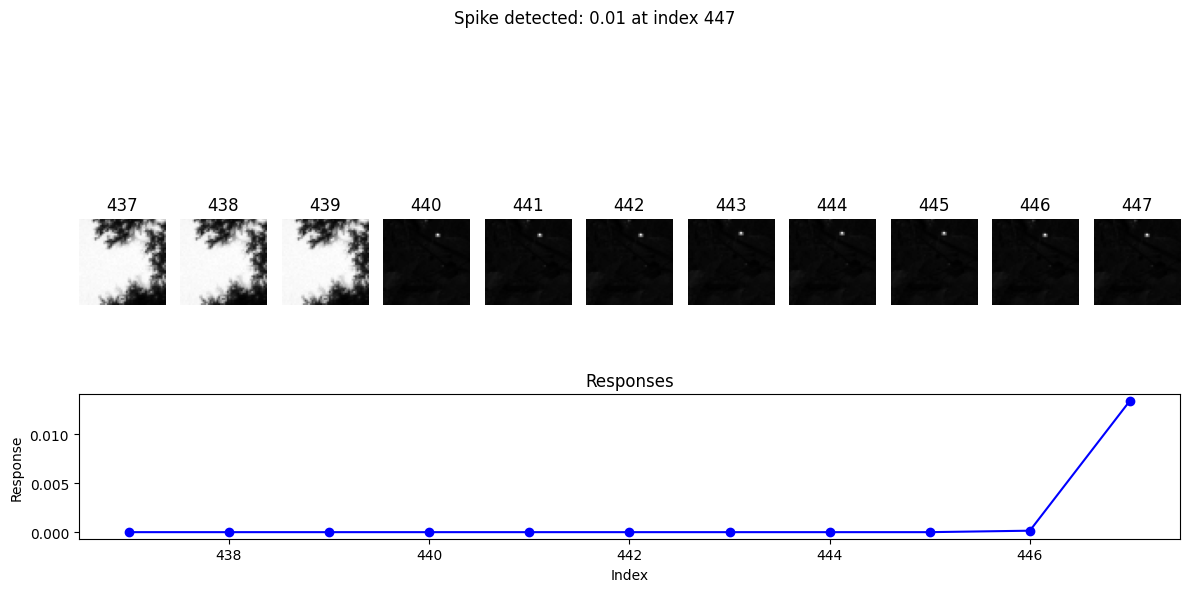

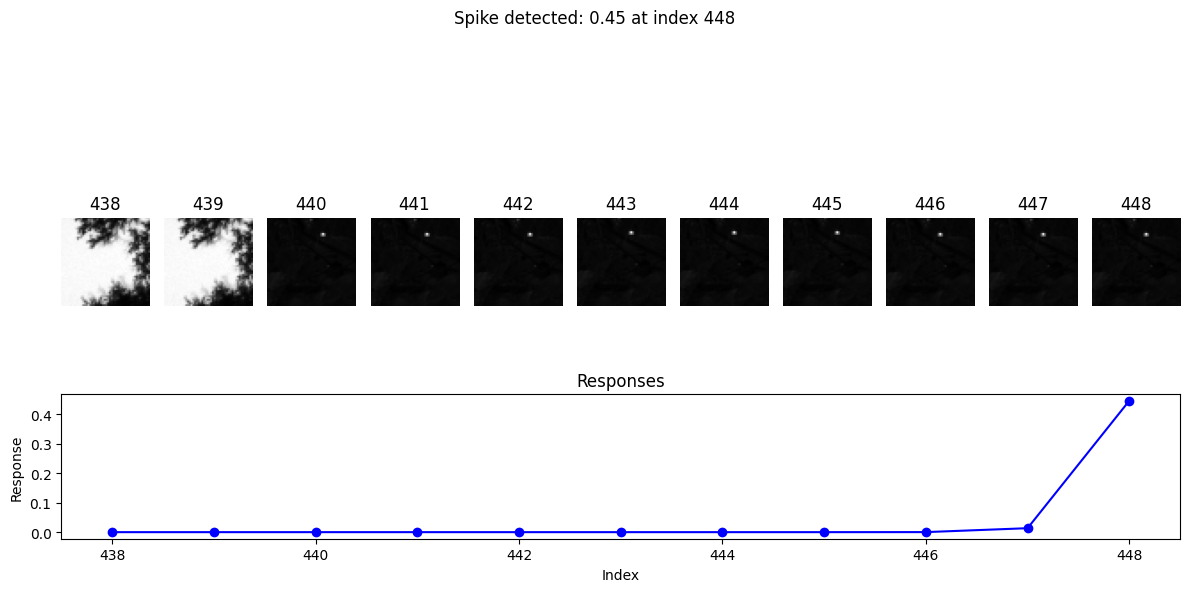

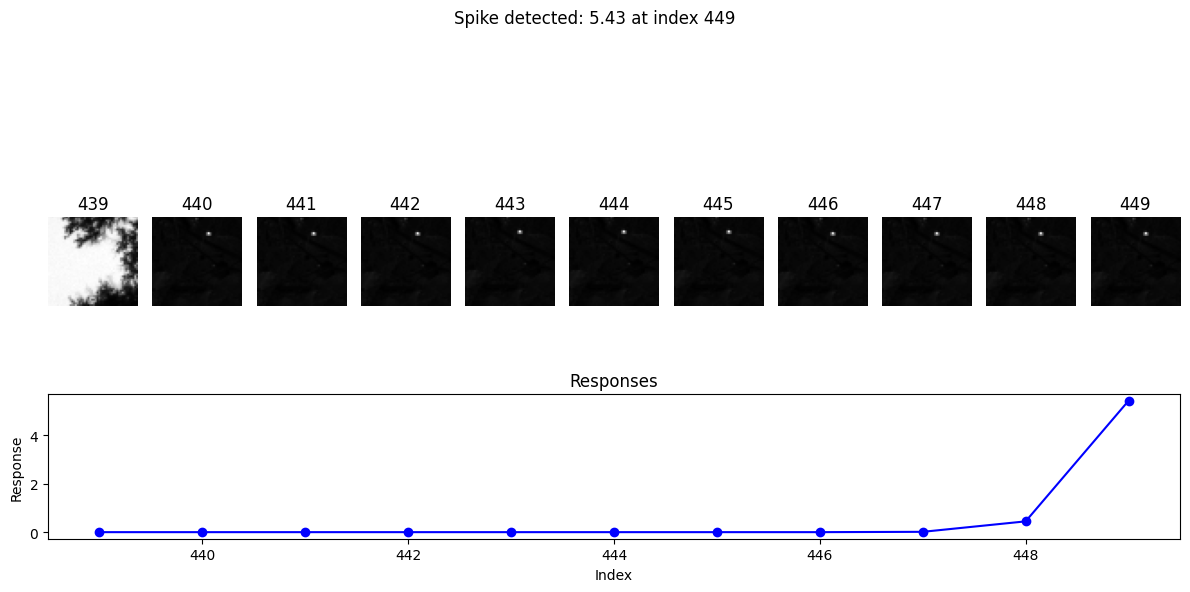

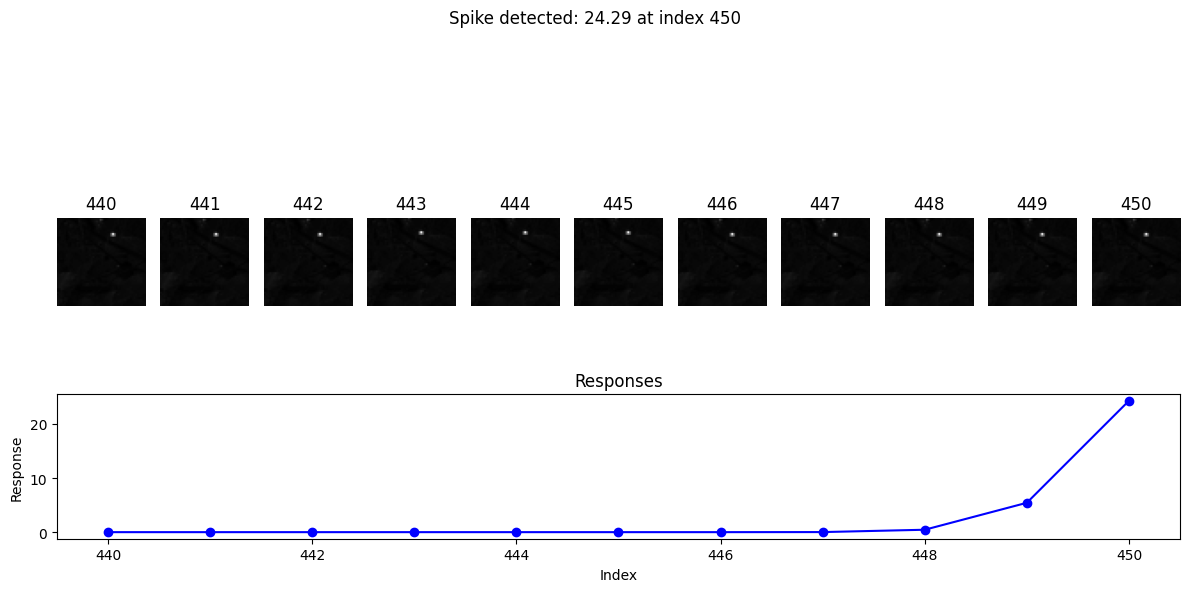

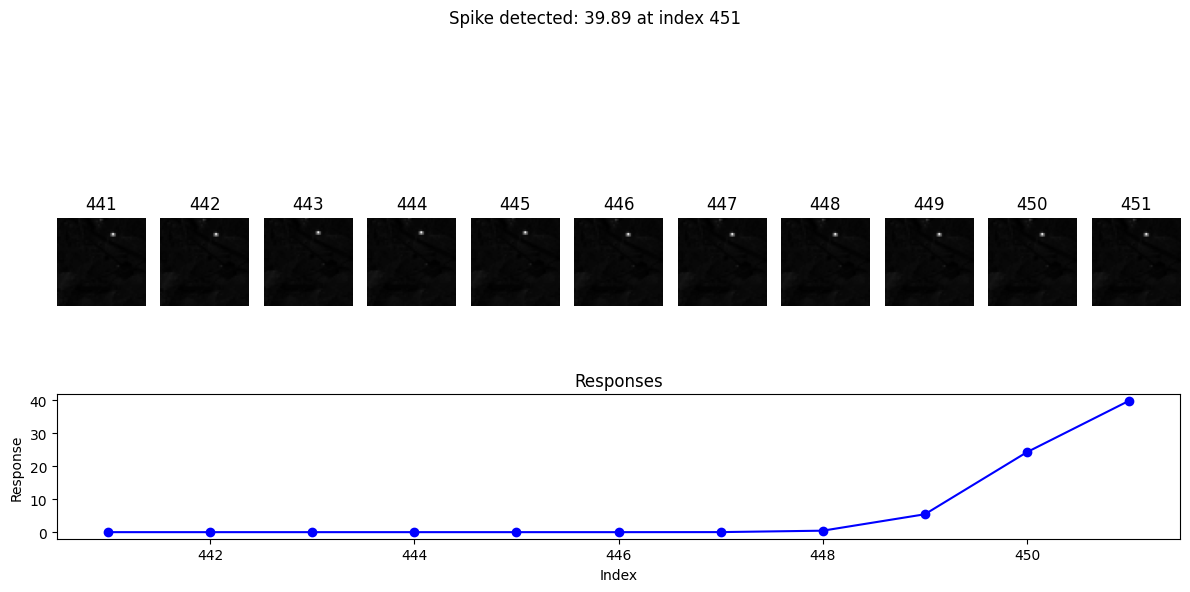

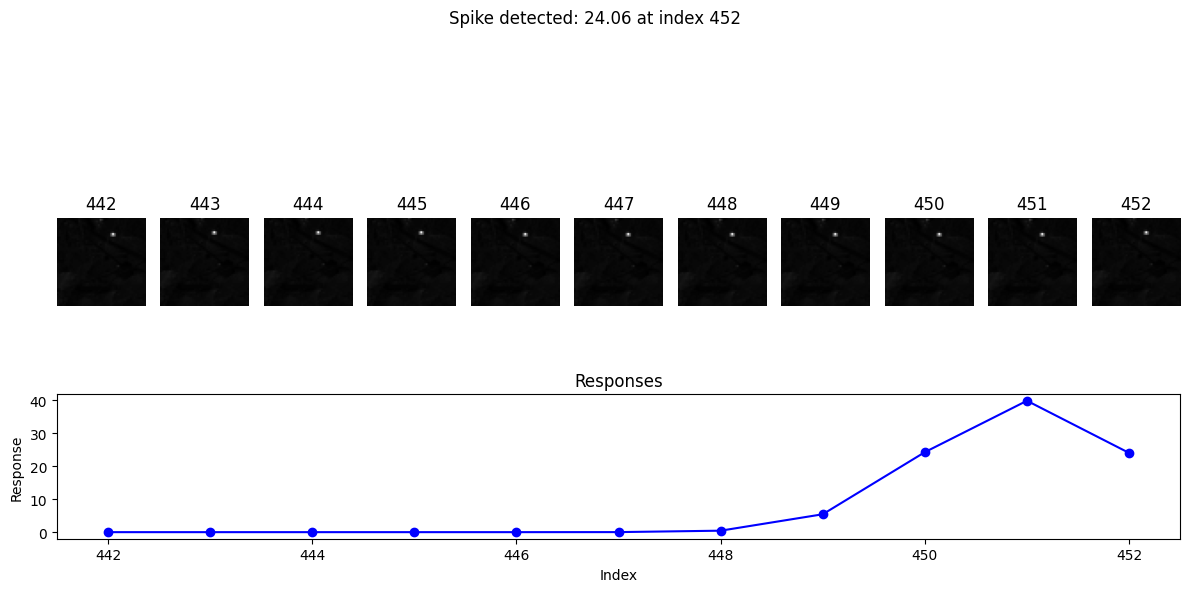

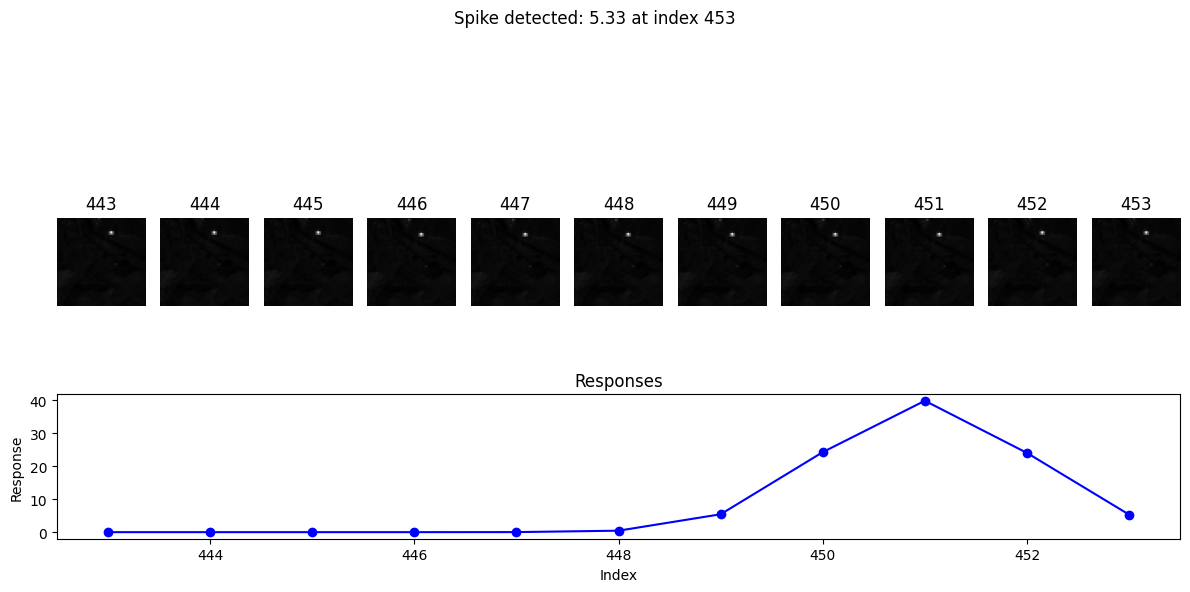

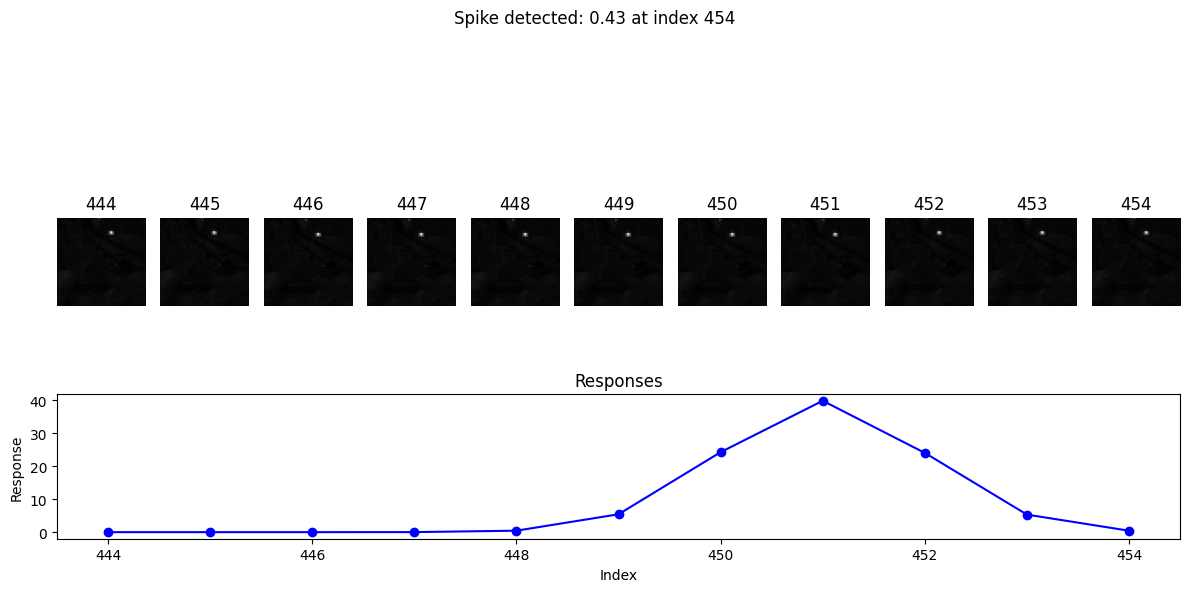

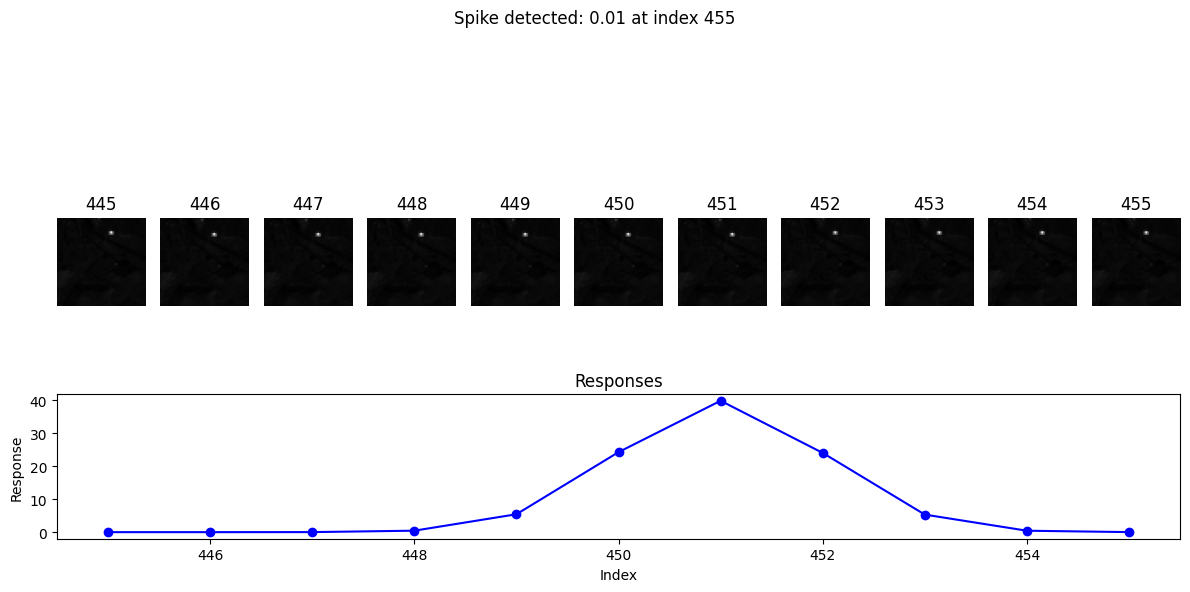

In [17]:
y_2 = y[2]
start = 1000
end = 1500
plot_spike_images(y_2[start:end], x[start:end], N=10)

No plots for other channels, the trend will be mostly the same.

# Tabular data

The goal of this section is to create the dataframe with analytical metadata about given spatio-temporal series


* start_index
* end_index
* MSE_0(start_index, start_index + 1)
* MSE_1(start_index + 1, start_index + 2)
* ...
* MSE_N(end_index - 1, end_index)
* SSIM_0(start_index, start_index + 1)
* SSIM_1(start_index + 1, start_index + 2)
* ...
* SSIM_N(end_index - 1, end_index)
* AVG_MSE(MSE_0, MSE_1, ..., MSE_X)
* AVG_SSIM(SSIM_0, SSIM_1, ..., SSIM_N)
* CHANNEL_0(end_index + 1)
* CHANNEL_1(end_index + 1)
* ...
* CHANNEL_8(end_index + 1)


In [23]:
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def compute_metadata(X, Y, window_size=10):
    num_frames = X.shape[0]
    metadata = []
    
    for start in tqdm(range(num_frames - window_size)):
        end = start + window_size - 1
        
        mse_values = [compute_mse(X[i], X[i+1]) for i in range(start, end)]
        ssim_values = [ssim(X[i], X[i+1], data_range=X[i].max() - X[i].min(), K1=0.0001) for i in range(start, end)]
        
        avg_mse = np.mean(mse_values)
        avg_ssim = np.mean(ssim_values)
        
        target_values = Y[:, end + 1]
        
        metadata.append([start, end] + mse_values + ssim_values + [avg_mse, avg_ssim] + list(target_values))
    
    columns = ["start_index", "end_index"]
    columns += [f"MSE_{i}" for i in range(window_size - 1)]
    columns += [f"SSIM_{i}" for i in range(window_size - 1)]
    columns += ["AVG_MSE", "AVG_SSIM"]
    columns += [f"CHANNEL_{i}" for i in range(9)]
    
    return pd.DataFrame(metadata, columns=columns)

In [24]:
df_metadata = compute_metadata(x, y)

  9%|▉         | 32649/359792 [01:32<15:18, 356.02it/s]d:\Studia\neural\Lib\site-packages\skimage\metrics\_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
100%|██████████| 359792/359792 [17:00<00:00, 352.51it/s]


In [22]:
df_metadata

,start_index,end_index,MSE_0,MSE_1,MSE_2,MSE_3,MSE_4,MSE_5,MSE_6,MSE_7,...,AVG_SSIM,CHANNEL_0,CHANNEL_1,CHANNEL_2,CHANNEL_3,CHANNEL_4,CHANNEL_5,CHANNEL_6,CHANNEL_7,CHANNEL_8
0,0,9,0.000000,0.000000,0.006869,0.000000,0.000000,0.004812,0.000000,0.000000,...,0.900631,103.845184,0.0,0.0,0.000000,0.000000,63.951359,0.013435,0.0,128.348465
1,1,10,0.000000,0.006869,0.000000,0.000000,0.004812,0.000000,0.000000,0.000000,...,0.900631,53.441868,0.0,0.0,0.000000,0.000149,29.384336,0.445748,0.0,64.198990
2,2,11,0.006869,0.000000,0.000000,0.004812,0.000000,0.000000,0.000000,0.000000,...,0.900631,11.086669,0.0,0.0,0.000149,0.013732,5.759867,5.430315,0.0,35.809891
3,3,12,0.000000,0.000000,0.004812,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.918762,0.879056,0.0,0.0,0.013435,0.472766,0.445991,24.290306,0.0,40.785809
4,4,13,0.000000,0.004812,0.000000,0.000000,0.000000,0.000000,0.000000,0.004812,...,0.918762,0.025855,0.0,0.0,0.445748,6.335247,0.012927,39.907257,0.0,24.083387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359787,359787,359796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.975561,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.012912,0.0,0.000000
359788,359788,359797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003401,...,0.975561,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
359789,359789,359798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003401,0.000000,...,0.975561,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
359790,359790,359799,0.000000,0.000000,0.000000,0.000000,0.000000,0.003401,0.000000,0.000000,...,0.951121,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [21]:
df_metadata.to_csv("../data/tabular/series_metadata.csv", index=False)